In [46]:
import pandas as pd 
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random as rnd
from networkx.algorithms import community
import re
import math

In [47]:
nodes = pd.read_csv('nodes.csv').loc[:,['id','label','born','died','continental','analytic']]
nodes = nodes[(nodes.continental == 1) | (nodes.analytic == 1)]
lone_nodes = ['n130', 'n478','n486','n489']
nodes = nodes[(nodes.id.isin(lone_nodes) == False)]

edges = pd.read_csv('edges.csv')
edges = edges[(edges['from'].isin(nodes.id)) & (edges['to'].isin(nodes.id))]

In [48]:
edges.to_csv('dedges.csv')

In [49]:
G = nx.Graph() 
color_map = []

for index, row in nodes.iterrows():

    if row.continental == 1:
        color_map.append('blue')
    elif row.analytic == 1:
        color_map.append('red')
    else: color_map.append('yellow')

    G.add_node(
        row.id, 
        label = row.label,
        born = row.born,
        died = row.died
    )

for index, row in edges.iterrows():

    G.add_edge(row['from'], row['to'])

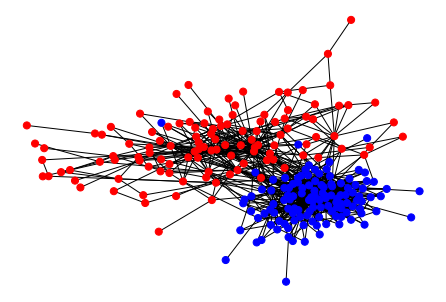

In [50]:
pos = nx.spring_layout(G)

options = {
    'node_color': color_map,
    'node_size': 50,
    'width': 1
}
nx.draw(G, **options, with_labels=False, pos = pos)

In [51]:
def create_comms(partition, name):

    ordered = []
    done = False

    if type(partition) is not tuple:
        while not done:
            done = True
            for g in range(0,len(partition)-1):
                if len(partition[g]) < len(partition[g+1]):
                    temp = partition[g+1]
                    partition[g+1] = partition[g]
                    partition[g] = temp
                    done = False

    for g in range(0,len(partition)):
        comm = name + str(g)
        nodes[comm] = [1 if n in list(partition[g]) else 0 for n in nodes.id]

def iter_comms(iterator, name):
    array = []
    for i in iterator:
        array.append(list(i))
    
    create_comms(array, name)


In [52]:
display(nodes)

,id,label,born,died,continental,analytic
21,n22,Edmund Husserl,1859-04-08 00:00:00,1938-04-27 00:00:00,1,0
51,n52,Bertrand Russell,1872-05-18 00:00:00,1970-02-02 00:00:00,0,1
54,n55,Martin Heidegger,1889-09-26 00:00:00,1976-05-26 00:00:00,1,0
56,n57,Xavier Zubiri,1898-12-04 00:00:00,1983-09-21 00:00:00,1,0
62,n63,Georg Wilhelm Friedrich Hegel,1770-08-27 00:00:00,1831-11-14 00:00:00,1,0
...,...,...,...,...,...,...
672,n673,David Stove,1927-09-15 00:00:00,1994-06-02 00:00:00,0,1
675,n676,Mladen Dolar,1951-01-29 00:00:00,NaN,1,0
686,n687,Stephen Darwall,1946-01-01,NaN,0,1
689,n690,Patrick Suppes,1922-03-17 00:00:00,2014-11-17 00:00:00,0,1


In [53]:
comms = []
for index, row in nodes.iterrows():
    comms.append(','.join(list(row[row == 1].keys())))
nodes['comms'] = comms

In [54]:
display(nodes)
nodes.to_csv('dnodes.csv')

,id,label,born,died,continental,analytic,comms
21,n22,Edmund Husserl,1859-04-08 00:00:00,1938-04-27 00:00:00,1,0,continental
51,n52,Bertrand Russell,1872-05-18 00:00:00,1970-02-02 00:00:00,0,1,analytic
54,n55,Martin Heidegger,1889-09-26 00:00:00,1976-05-26 00:00:00,1,0,continental
56,n57,Xavier Zubiri,1898-12-04 00:00:00,1983-09-21 00:00:00,1,0,continental
62,n63,Georg Wilhelm Friedrich Hegel,1770-08-27 00:00:00,1831-11-14 00:00:00,1,0,continental
...,...,...,...,...,...,...,...
672,n673,David Stove,1927-09-15 00:00:00,1994-06-02 00:00:00,0,1,analytic
675,n676,Mladen Dolar,1951-01-29 00:00:00,NaN,1,0,continental
686,n687,Stephen Darwall,1946-01-01,NaN,0,1,analytic
689,n690,Patrick Suppes,1922-03-17 00:00:00,2014-11-17 00:00:00,0,1,analytic


In [55]:
def color_gen(name, title):

    color_map = []

    for index, row in nodes.iterrows():
        if row[name + '0'] == 1:
            color_map.append('blue')
        elif row[name + '1'] == 1:
            color_map.append('red')
        else: color_map.append('yellow')

    options = {
        'node_color': color_map,
        'node_size': 50,
        'width': 1
    }
    
    nx.draw(G, **options, with_labels=False, pos = pos)
    plt.title(title)
    plt.show()
    display(pd.crosstab(nodes.continental, nodes[name + '0'], rownames = ['Actual'], colnames = ['Predicted']))

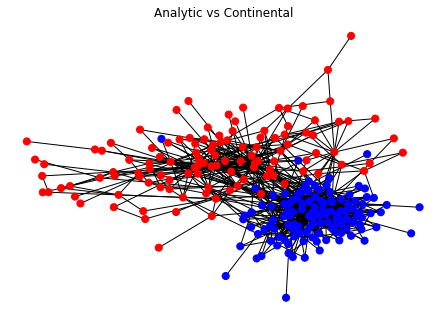

In [56]:
nx.draw(G, **options, with_labels=False, pos = pos)
plt.title('Analytic vs Continental')
plt.show()

## Kernighan-Lin Bisection

This method wasn't originally intended to be a community detection algorithm, rather, its purpose was to divide a graph into two partitions with the minimal number of connections between the partitions. In the original paper (http://xilinx.asia/_hdl/4/eda.ee.ucla.edu/EE201A-04Spring/kl.pdf), the example they use are circuit boards. The components of an electronic circuit are printed onto multiple circuit cards but connections between these cards are relatively costly. Therefore, finding ways to divide these connected components onto different cards with minimal cross-card connections was desirable.

This heuristic method can be used effectively for community detection when you know a graph contains two similarily sized groups. Luckily this is the case with the philosopher subnetwork of analytical and continental philosophers. This method starts by bisecting the graph into two separate groups of nodes, usually at random. Then for each node it calculates the number of edges it shares with its ingroup and its outgroup. To reduce the number of edges between groups it's best to have minimal outgroup edges. On the otherhand, having many ingroup edges means if the node was moved into the other group it would then have many outgroup edges which is undesirable. Therefore, this method takes the difference between the number of outgroup edges and ingroup edges as it's heuristic (D = OUT - IN). For each group it finds the nodes with the maximal difference between their number of outgroup edges and ingroup edges then swaps them. This is the optimal single swap for minimizing outgroup edges. It then recalculates the number of ingroup edges and outgroup edges for every node and again identifies the optimal swap. It can repeat this n times and approaches an optimal solution. 

https://en.wikipedia.org/wiki/Kernighan%E2%80%93Lin_algorithm


In [57]:
def n_adjacents(node, nset):

    ctr = 0

    for n in G.neighbors(node):
        if n in nset: ctr = ctr + 1
    
    return ctr

def set_inout_difference(inset, outset):

    for node in inset:
        inset[node] = n_adjacents(node, outset) - n_adjacents(node, inset)

def klb(G, iter):

    rand = [i for i in range(G.number_of_nodes())]
    rnd.shuffle(rand)

    set1 = {}
    set2 = {}

    for i in range(len(rand)):
        if i < len(rand) / 2:
            set1[list(G.nodes)[rand[i]]] = None
        else: set2[list(G.nodes)[rand[i]]] = None

    for i in range(iter):

        set_inout_difference(set1,set2)
        set_inout_difference(set2,set1)
        
        n1 = max(set1, key = set1.get)
        n2 = max(set2, key = set2.get)

        set1.pop(n1)
        set2.pop(n2)

        set1[n2] = None
        set2[n1] = None

    return [set1, set2]




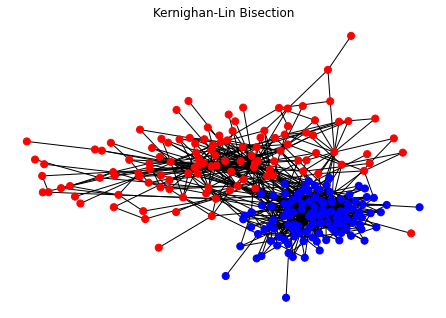

Predicted,0,1
Actual,,
0,113,2
1,5,115


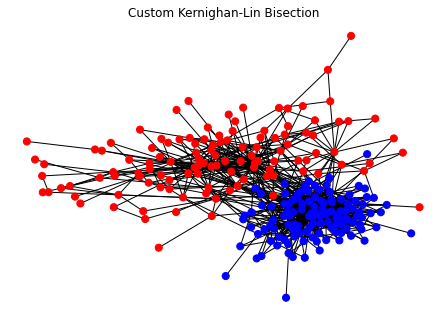

Predicted,0,1
Actual,,
0,113,2
1,4,116


In [58]:
create_comms(community.kernighan_lin_bisection(G, max_iter = 500), 'klb')
create_comms(klb(G, 500), 'custom_klb')
color_gen('klb', 'Kernighan-Lin Bisection')
color_gen('custom_klb', 'Custom Kernighan-Lin Bisection')

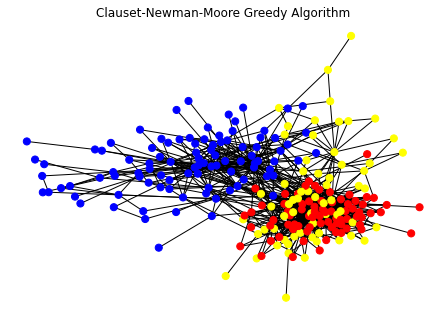

Predicted,0,1
Actual,,
0,22,93
1,117,3


In [59]:
create_comms(community.greedy_modularity_communities(G), 'cnm')
color_gen('cnm', 'Clauset-Newman-Moore Greedy Algorithm')

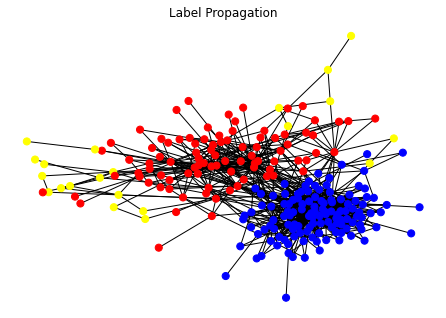

Predicted,0,1
Actual,,
0,109,6
1,2,118


In [60]:
iter_comms(community.label_propagation_communities(G), 'lab')
color_gen('lab', 'Label Propagation')

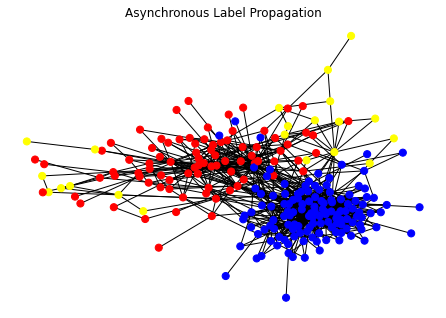

Predicted,0,1
Actual,,
0,103,12
1,2,118


In [61]:
iter_comms(community.asyn_lpa_communities(G, seed = 1), 'alab')
color_gen('alab', 'Asynchronous Label Propagation')

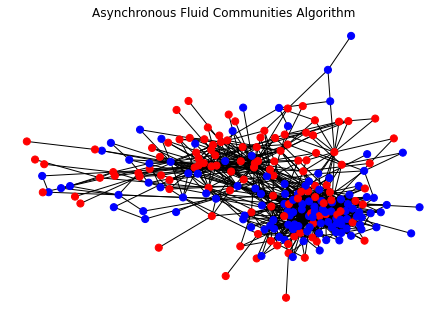

Predicted,0,1
Actual,,
0,76,39
1,40,80


In [62]:
iter_comms(community.asyn_fluidc(G, 2, seed = 1), 'aflu')
color_gen('aflu', 'Asynchronous Fluid Communities Algorithm')

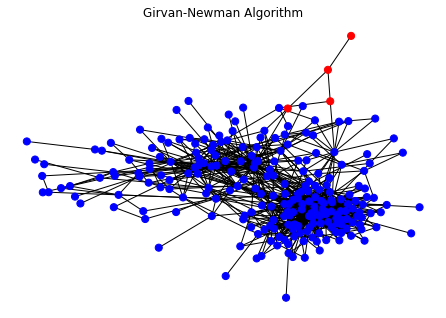

Predicted,0,1
Actual,,
0,4,111
1,0,120


In [63]:
gnew = community.girvan_newman(G)
create_comms(list(sorted(c) for c in next(gnew)), 'gnew')
color_gen('gnew', 'Girvan-Newman Algorithm')